## Reading in the DataFrame from the CSV file made from Featurization

In [1]:
# Read in DataFrame from CSV file
import pandas as pd
df = pd.read_csv('output.csv')
data=df
print('Loaded {} entries'.format(len(data)))

Loaded 559 entries


## Importing Libraries and and making seeds for random numbers

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pickle
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

random.seed(1)
torch.manual_seed(1)
np.random.seed(1)

## assign features (features) and targets (Temp) to numpy arrays

In [3]:
#features = data.drop('e_fr_energy', axis=1)
features = data.drop('e_fr_energy', axis=1)
features = np.array(features)
Temp = data['e_fr_energy'].values
print(Temp.shape)
print(features.shape)

(559,)
(559, 232)


## Data Loader and Splitting data set

In [20]:
Train_val_X, test_X, Train_Y, test_Y = train_test_split(features, Temp, test_size=0.1)
train_X, val_X, train_Y, val_Y = train_test_split(Train_val_X, Train_Y, test_size=0.1)
print(f'train_X.shape: {train_X.shape}, train_Y.shape: {np.array(train_Y).shape}')
print(f'val_X.shape: {val_X.shape}, val_Y.shape: {np.array(val_Y).shape}')
print(f'test_X.shape: {test_X.shape}, test_Y.shape: {np.array(test_Y).shape}')

l0=features.shape[1]
print('number of inputs for first layer: ', l0)

train_X.shape: (452, 232), train_Y.shape: (452,)
val_X.shape: (51, 232), val_Y.shape: (51,)
test_X.shape: (56, 232), test_Y.shape: (56,)
number of inputs for first layer:  232


## PCA Analysis = reduce the number of variables of a data set, while preserving as much information as possible.

https://builtin.com/data-science/step-step-explanation-principal-component-analysis

Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process.


PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system 

such that the greatest variance () by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.[12]

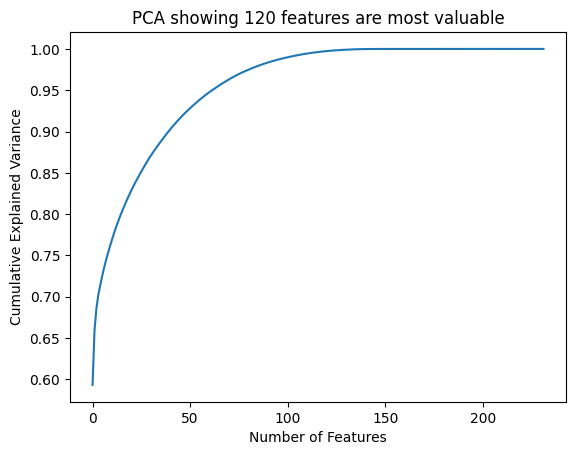

In [29]:
from sklearn.decomposition import PCA
import matplotlib as mpl 
mpl.rcParams.update(mpl.rcParamsDefault)
##%matplotlib inline
#import seaborn as sns; sns.set()
pca = PCA().fit(train_X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.title("PCA showing 120 features are most valuable")
plt.show()
plt.clf()

## feature engineering
put in training data above 

Selecting  N features with the variance less than 1 CEA

this is already fitted to new coordinate system, we are transforming 

In [11]:
N = 120 # num of features 
pca = PCA(N)  # set up PCA, letting it know the num of parameters.
pca.fit(Train_val_X)

PCA(n_components=120)

## transform data that will be used to retrain the model

In [12]:
Train_X = pca.transform(train_X) 
Val_X = pca.transform(val_X)
Test_X = pca.transform(test_X)
l0=Train_X.shape[1]

print('Train_X shape: ',Train_X.shape)
print('Val_X shape: ',Val_X.shape)
print('Test_X shape: ',Test_X.shape)
print('number of inputs for first layer: ', l0)

Train_X shape:  (452, 120)
Val_X shape:  (51, 120)
Test_X shape:  (56, 120)
number of inputs for first layer:  120


## Define Model and Data Loader

In [18]:
class Dataset():
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = self.list_IDs[index]
        y = self.labels[index]
        return X, y

def data_loader_fn(X, Y, batch_size, shuffle, drop_last):
    data_tensor = torch.tensor(X, dtype=torch.float32)    #all_img test_x, test_y
    target_tensor = torch.tensor(Y, dtype=torch.float32)   #target

    dataset = Dataset(data_tensor, target_tensor)
    data_loader = DataLoader(dataset,  batch_size = batch_size, shuffle = shuffle, drop_last=drop_last) #model_micro.eval()
    return data_loader


class MLP(nn.Module):
    def __init__(self, l1=120, l2=84, p = 0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(l0, l1) # define layer number of input/outputs : input l0 neurons, output hidden layer with l1 neurons
        self.fc2 = nn.Linear(l1, l2) # define layer number of input/outputs :  input l1 neurons, output with l2 neurons 
        self.fc3 = nn.Linear(l2, 1) # define layer number of input/outputs :  input l2 neurons, output with 1 neurons 
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x) # first layer (fc1) takes 100 inputs (100 x's) and outputs l1 outputs (l1 x's) 
        x = F.relu(x) # activation function transforms x values in l1 tensor
        x = self.fc2(x) # second layer (fc2) takes the outputs of fc1 and outputs l2 outputs (l2 x's) 
        x = F.relu(x) # activation function transforms x values in l2 tensor
        
        x = self.dropout(x) # has probability p 
        x = self.fc3(x)
        return x
    
criterion = nn.MSELoss()
mae = nn.L1Loss()

# cross entropy loss ?

learning_rate = 1.0e-4
model = MLP(l1=120, l2=84 , p=0.2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#,0.000225

# Training

In [21]:
batch_size=20
train_loader = data_loader_fn(Train_X, train_Y, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = data_loader_fn(Val_X, val_Y, batch_size=batch_size, shuffle=True, drop_last=False)

running_loss_list = []
val_running_loss_list = []

performance_record = {'loss':[], 'val_loss': []}

early_stop_thresh = 20
best_loss = 100000000
best_epoch = 0
epochs = 500
for epoch in range(1, epochs):
    running_loss = []
    val_running_loss = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward  + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

   # evaluate with validation
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):

            inputs, labels = data
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss.append(val_loss.item())


    running_loss_list.append(float(f'{np.mean(running_loss) :.4f}'))
    val_running_loss_list.append(float(f'{np.mean(val_running_loss):.4f}'))

    print(f'Epoch{epoch}: loss: {np.mean(running_loss):.4f} val_loss: {np.mean(val_running_loss):.4f}')
    this_loss = np.mean(val_running_loss)

    if this_loss < best_loss:
        best_loss = this_loss
        best_epoch = epoch
        #checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

performance_record['loss'] += running_loss_list

performance_record['val_loss'] += val_running_loss_list

/nas/longleaf/home/jarkeith/.conda/envs/TorchANI/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/nas/longleaf/home/jarkeith/.conda/envs/TorchANI/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/nas/longleaf/home/jarkeith/.conda/envs/TorchANI/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likel

Epoch1: loss: 2659780.1848 val_loss: 2658917.1667
Epoch2: loss: 2658351.7935 val_loss: 2657127.4167
Epoch3: loss: 2656633.8478 val_loss: 2655368.6667
Epoch4: loss: 2654650.3696 val_loss: 2652925.8333
Epoch5: loss: 2652024.4565 val_loss: 2649874.7500
Epoch6: loss: 2648886.1304 val_loss: 2646319.7500
Epoch7: loss: 2644935.3152 val_loss: 2641928.9167
Epoch8: loss: 2640520.4457 val_loss: 2637047.7500
Epoch9: loss: 2635452.5978 val_loss: 2631753.5833
Epoch10: loss: 2629806.3913 val_loss: 2625630.1667
Epoch11: loss: 2622918.3370 val_loss: 2618376.4167
Epoch12: loss: 2615675.7065 val_loss: 2611660.0000
Epoch13: loss: 2607524.3804 val_loss: 2602282.1667
Epoch14: loss: 2596609.6087 val_loss: 2593128.6667
Epoch15: loss: 2587479.1196 val_loss: 2582140.5000
Epoch16: loss: 2576963.0652 val_loss: 2571995.0000
Epoch17: loss: 2564268.6413 val_loss: 2559555.8333
Epoch18: loss: 2550770.9130 val_loss: 2550055.0000
Epoch19: loss: 2534699.8696 val_loss: 2528306.9167
Epoch20: loss: 2519740.1087 val_loss: 25

## Save Trained Model

In [22]:
PATH = f'GAP_model_PCA_1.pth'
torch.save(model.state_dict(), PATH)

## Load Trained Model

In [23]:
# specify path
PATH = f'GAP_model_PCA_1.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

MLP(
  (fc1): Linear(in_features=120, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## How does the Model Learn?

<Figure size 640x480 with 0 Axes>

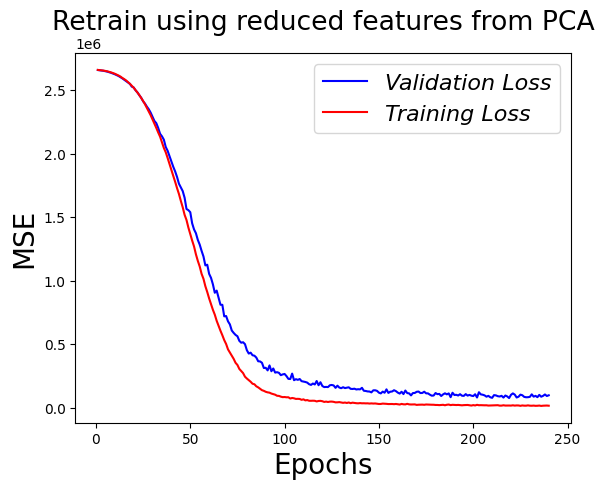

In [28]:
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import *


loss_values = performance_record['loss']
val_loss_values = performance_record['val_loss']

epochs = range(1, len(val_loss_values) + 1)
N = 200

fig, ax1 = plt.subplots()
rc('axes', linewidth=1.5)
plt.rcParams['font.size'] = '16'
#plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.style'] = 'italic'
plt.xlabel('Epochs', size=20)
plt.ylabel('MSE', size=20)


plt.rcParams.update({'figure.figsize': (12.0, 8.0)})

ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, 'b', label = 'Validation Loss')
ax1.plot(range(1, len(loss_values) + 1), loss_values, 'r', label = 'Training Loss')
plt.title("Retrain using reduced features from PCA")
plt.legend()

#plt.savefig("/noether/s0/iam5249/IM_models/IM_coverage_loss_micro_whole_10_New_patch_feature_best.png", dpi=600)
plt.show()

## Testing the model

In [26]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


test_loader = data_loader_fn(Test_X, test_Y, batch_size=batch_size, shuffle=False, drop_last=False)

model.eval()
Test_Y = []
Test_Y_pred = []

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    outputs = model(inputs)
    Test_Y += labels.tolist()
    Test_Y_pred += outputs.tolist()

test_mean_absolute_error = mae(Test_Y, Test_Y_pred)
print(test_mean_absolute_error)

184.6335928780692
